In [1]:
import numpy as np
import plotly.graph_objects as go
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from typing import List, Union
import scipy.optimize as spo
from collections import Counter

In [2]:
class Fiber_pair:
    def __init__(self, core_r = 0,   clad_r = 0,   core_n = 0,   clad_n = 0,
                       core_r_2 = 0, clad_r_2 = 0, core_n_2 = 0, clad_n_2 = 0, 
                       z_max = 0, diffusion = None):
        self.diffusion = diffusion
        self.core_r = core_r
        self.clad_r = clad_r
        self.core_n = core_n
        self.clad_n = clad_n
        self.core_r_2 = core_r_2
        self.clad_r_2 = clad_r_2
        self.core_n_2 = core_n_2
        self.clad_n_2 = clad_n_2
        self.z_max = z_max
    def set_geometry(self, core_r, clad_r, core_r_2, clad_r_2, z): #радиусы принимаются в метрах
        self.core_r = core_r
        self.clad_r = clad_r
        self.core_r_2 = core_r_2
        self.clad_r_2 = clad_r_2
        self.z_max = z
    def set_refr(self, core_n, clad_n, core_n_2, clad_n_2):
        self.core_n = core_n
        self.clad_n = clad_n
        self.core_n_2 = core_n_2
        self.clad_n_2 = clad_n_2
    def radius(self):
        return self.core_r, self.clad_r, self.core_r_2, self.clad_r_2
    def refr(self):
        return self.core_n, self.clad_n, self.core_n_2, self.clad_n_2 
    def find_normal(self, intersection_point):
        x, y = intersection_point[:2]
        result = -1 * np.array([x, y, 0])/np.sqrt(x**2 + y**2)
        return result # Возвращает нормаль к поверхности, направленную к центру цилиндра

In [3]:
class Fiber_cylinder:
    def __init__(self, core_r = 0, clad_r = 0, core_n = 0, clad_n = 0, z_max = 0, diffusion = None):
        self.diffusion = diffusion
        self.core_r = core_r
        self.clad_r = clad_r
        self.core_n = core_n
        self.clad_n = clad_n
        self.z_max = z_max
    def set_geometry(self, core_r, clad_r, z): #радиусы принимаются в метрах
        self.core_r = core_r
        self.clad_r = clad_r
        self.z_max = z
    def set_refr(self, core_n, clad_n):
        self.core_n = core_n
        self.clad_n = clad_n
    def radius(self):
        return self.core_r, self.clad_r
    def refr(self):
        return self.core_n, self.clad_n
    def find_normal(self, intersection_point):
        x, y = intersection_point[:2]
        result = -1 * np.array([x, y, 0])/np.sqrt(x**2 + y**2)
        return result # Возвращает нормаль к поверхности, направленную к центру цилиндра
    

In [4]:
class Ray_pair:
    def __init__(self, azimut = 0, latitude = 0, startpoint = [0,0,0]): #все углы принимаются в радианах
        self.index = True
        self.azimut = azimut
        self.latitude = latitude
        self.startpoint = startpoint
        self.vector = [np.sin(latitude)*np.cos(azimut),
                      np.sin(latitude)*np.sin(azimut), 
                      np.cos(latitude)]
    
    def set_values(self, azimut, latitude, startpoint):
        self.azimut = azimut
        self.latitude = latitude
        self.startpoint = startpoint
        self.vector = [np.sin(latitude)*np.cos(azimut),
                      np.sin(latitude)*np.sin(azimut), 
                      np.cos(latitude)]
    def calculate_angles_from_vector(self, vector):
        latitude = np.arccos(vector[2])
        if latitude == 0:
            return [0, 0]
        cos = vector[0] / np.linalg.norm(vector[:2])
        sin = vector[1] / np.linalg.norm(vector[:2])
        if sin > 0:
            azimut = np.arccos(cos)
        else:
            azimut = -np.arccos(cos)
        return [azimut, latitude]
    
    def calculate_intersection(self, core_radius):
        if self.latitude == 0:
            return [*self.startpoint[:2], -1]
        x0, y0, z0 = self.startpoint
        phi, alpha = self.azimut, self.latitude
        R = core_radius
        gamma = np.cos(phi)*x0 + np.sin(phi)*y0
        x = x0 + np.cos(phi) * (-gamma + np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))
        y = y0 + np.sin(phi) * (-gamma + np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))
        z = z0 + np.cos(alpha) / np.sin(alpha) * (-gamma + np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))

        return [x, y, z]
    
    def calculate_reflection(self, point, normal):
        angle  = np.dot(normal, self.vector)
        proection = normal * angle
        reflected_vector = -2 * proection + self.vector
        return *self.calculate_angles_from_vector(reflected_vector), angle
    
    def generate_startpoint(self, radius):
        phi = np.random.random() * np.pi
        r = np.random.random() * radius
        coords = [r*np.cos(phi), r*np.sin(phi)]
        self.startpoint = [*coords, 0]
        return [*coords, 0]
    
    def set_startpoint(self, x = 0, y = 0, z = 0):
        self.startpoint = [x, y, z]
        return self.startpoint
    
    def generate_angles(self, max_latitude = 30):
        latitude = np.deg2rad(np.random.random() * max_latitude)
        azimut = np.deg2rad(np.random.random() * 360)
        self.azimut = azimut
        self.latitude = latitude
        self.vector = [np.sin(latitude)*np.cos(azimut),
                      np.sin(latitude)*np.sin(azimut), 
                      np.cos(latitude)]
        return [latitude, azimut]
        
    def set_angles(self, azimut, latitude):
        self.azimut = azimut
        self.latitude = latitude
        self.vector = [np.sin(latitude)*np.cos(azimut),
                      np.sin(latitude)*np.sin(azimut), 
                      np.cos(latitude)]
        return [latitude, azimut]
    
    def calculate_trajectory(self, fiber1, fiber2, max_reflection = 1000, angle_elimination = True, output = False):
        z_max = fiber1.z_max
        termination_angle = np.arcsin(fiber1.clad_n / fiber1.core_n)
        Dots = np.zeros((max_reflection, 3))
        reflection_angle = self.latitude
        Angles = np.zeros((max_reflection, 3))
        indexes = np.zeros(max_reflection)
        z_start = self.startpoint[2]
        indexes[0] = self.index
        Dots[0] = self.startpoint
        Angles[0] = [self.azimut, self.latitude, 0]
        for i in range(1, max_reflection):
            if self.index:
                intersection_point = self.calculate_intersection(fiber1.core_r)
            else:
                intersection_point = self.calculate_intersection(fiber2.core_r)
            if intersection_point[0] > fiber1.core_r * 0.8 and self.index == True:
                indexes[i] = self.index
                self.index = False
                Dots[i] = intersection_point
                Dots[i][0] *= 0.8
                Angles[i] = [self.azimut, self.latitude, 0]
                i += 1
                indexes[i] = self.index
                Dots[i] = intersection_point
                Dots[i][0] *= -0.8
                Angles[i] = [self.azimut, self.latitude, 0]
                self.set_values(self.azimut, self.latitude, Dots[i])
                continue
            elif intersection_point[0] < fiber2.core_r * -0.8 and self.index == False:
                indexes[i] = self.index
                self.index = True
                Dots[i] = intersection_point
                Dots[i][0] *= 0.8
                Angles[i] = [self.azimut, self.latitude, 0]
                i += 1
                indexes[i] = self.index
                Dots[i] = intersection_point
                Dots[i][0] *= -0.8
                Angles[i] = [self.azimut, self.latitude, 0]
                self.set_values(self.azimut, self.latitude, Dots[i])
                continue
            if intersection_point[2] > z_max:
                intersection_final = intersection_point - self.vector / self.vector[2] * (intersection_point[2] - z_max) 
                Dots[i] = intersection_final
                Angles[i] = [self.azimut, self.latitude, abs(reflection_angle)]
                indexes[i] = self.index
                if output:
                    print('Ray reached z_max.')
                return Dots, np.rad2deg(Angles), i + 1, 'z_max', indexes
            if self.index:
                normal = fiber1.find_normal(intersection_point)
            else:
                normal = fiber2.find_normal(intersection_point)
            azimut, latitude, reflection_angle = self.calculate_reflection(intersection_point, normal)
            if fiber1.diffusion:
                azimut += (np.random.random() - 0.5 ) * 2 * fiber1.diffusion
                latitude += (np.random.random() - 0.5 ) * 2 * fiber1.diffusion
            Dots[i] = intersection_point
            Angles[i] = [azimut, latitude, abs(reflection_angle)]
            indexes[i] = self.index
            if angle_elimination:
                if np.pi / 2 - abs(reflection_angle) < termination_angle:
                    if output:
                        print('Ray terminated, termination angle: ', np.rad2deg(termination_angle),' reflection_angle: ',  np.rad2deg(np.pi / 2 - abs(reflection_angle)))
                    return Dots, np.rad2deg(Angles), i + 1, 'reflection_angle', indexes
            self.set_values(azimut, latitude, intersection_point)
        if output:
            print('Reflections exceeded', max_reflection)
        return Dots, np.rad2deg(Angles), max_reflection, 'max_reflections', indexes

In [5]:
def calculate_multiple_trajectories_pair(fiber1, fiber2, trajectory_count = 100, max_reflection = 1000, output = False, angle = 8, startpoints = None, startangles = None):
    trajectories = np.zeros((trajectory_count, max_reflection, 3))
    angles = np.zeros((trajectory_count, max_reflection, 3))
    indexes = np.zeros((trajectory_count, max_reflection))
    reflections = np.zeros(trajectory_count)
    termination = ["" for x in range(trajectory_count)] # 0 - max_z, 1 - max_reflection, 2 - reflection angle
    ray_internal = Ray_pair()
    for i in tqdm(range(trajectory_count), leave = False):
        
        if startpoints:
            ray_internal.set_startpoint(*startpoints[i])
        else:
            ray_internal.generate_startpoint(fiber1.core_r)
         
        if startangles:
            ray_internal.set_angles(*startangles[i])
        else:    
            ray_internal.generate_angles(angle)
            
            
        trajectories[i], angles[i], reflections[i], termination[i], indexes[i] = ray_internal.calculate_trajectory(fiber1, fiber2, max_reflection=max_reflection, output = output)
    dictionary = {
        'angles':       angles.tolist(),
        'trajectories': trajectories.tolist(),
        'reflections':  reflections.tolist(),
        'termination':  termination,
        'indexes':        indexes.tolist()
    }
    return pd.DataFrame(dictionary)

In [6]:
fiber_1 = Fiber_cylinder(core_r=330e-6, clad_r=660e-6, core_n=1.445, clad_n=1.44, z_max=2)
fiber_2 = Fiber_cylinder(core_r=330e-6, clad_r=660e-6, core_n=1.445, clad_n=1.44, z_max=2)

data = calculate_multiple_trajectories_pair(fiber_1, fiber_2, trajectory_count = int(1e3), output=False, angle = 5)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
data_filtered = data[data.termination=='z_max'].reset_index()
x = np.linspace(0, 2, 100, endpoint=True)
ray_count = np.zeros(len(x))
for i in tqdm(range(len(x))):
    for j in tqdm(range(data_filtered.shape[0]), leave=False):
        z_array = [data_filtered.trajectories[j][k][2] for k in range(int(data_filtered.reflections[j]))]
        ind = int(next((y[0] for y in enumerate(z_array) if y[1] > x[i]), -1))
        ray_count[i] += data_filtered.indexes[j][ind]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

  0%|          | 0/951 [00:00<?, ?it/s]

In [8]:
ray_count = ray_count[:-1]
ray_count_2 = [data_filtered.shape[0] - i for i in ray_count]
x = x[:-1]

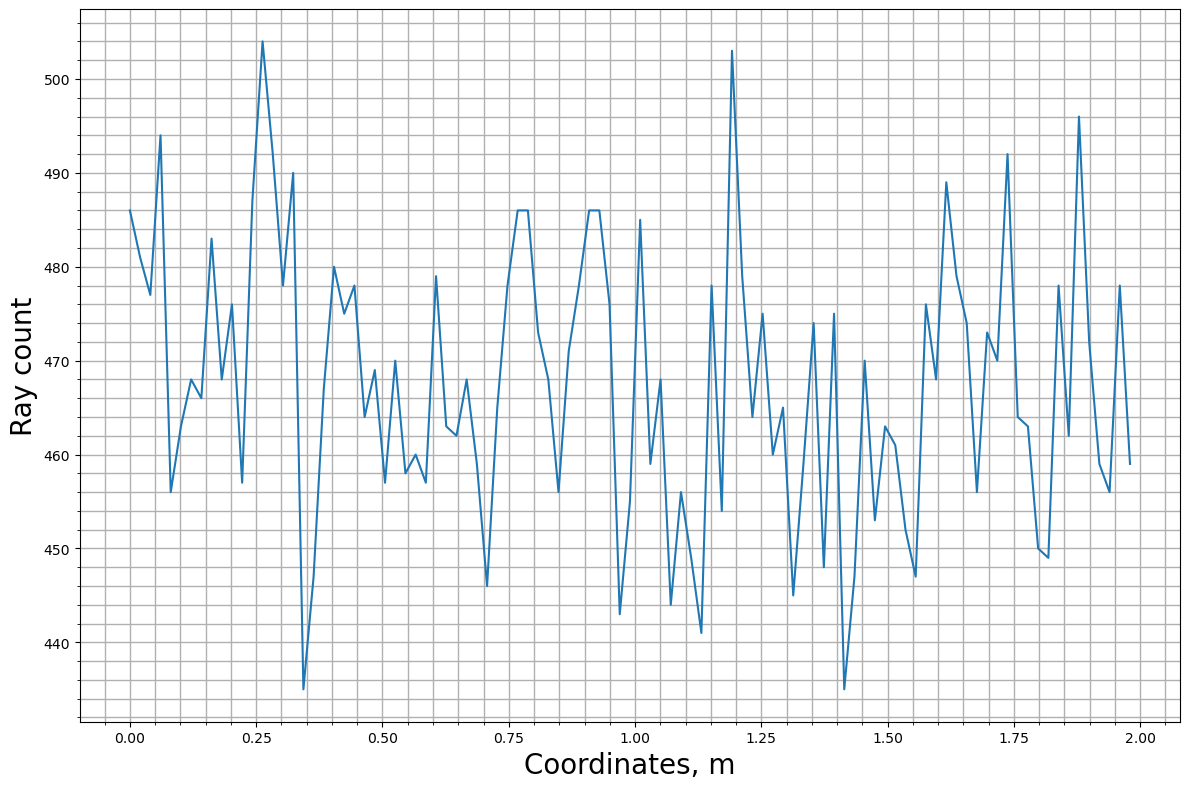

In [9]:
plt.figure(figsize = (12, 8))
plt.plot(x, ray_count, label='Rays in 1st fiber')

plt.xlabel('Coordinates, m', fontsize = 20)
plt.ylabel('Ray count', fontsize = 20)
plt.minorticks_on()
plt.grid(which="both", linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()

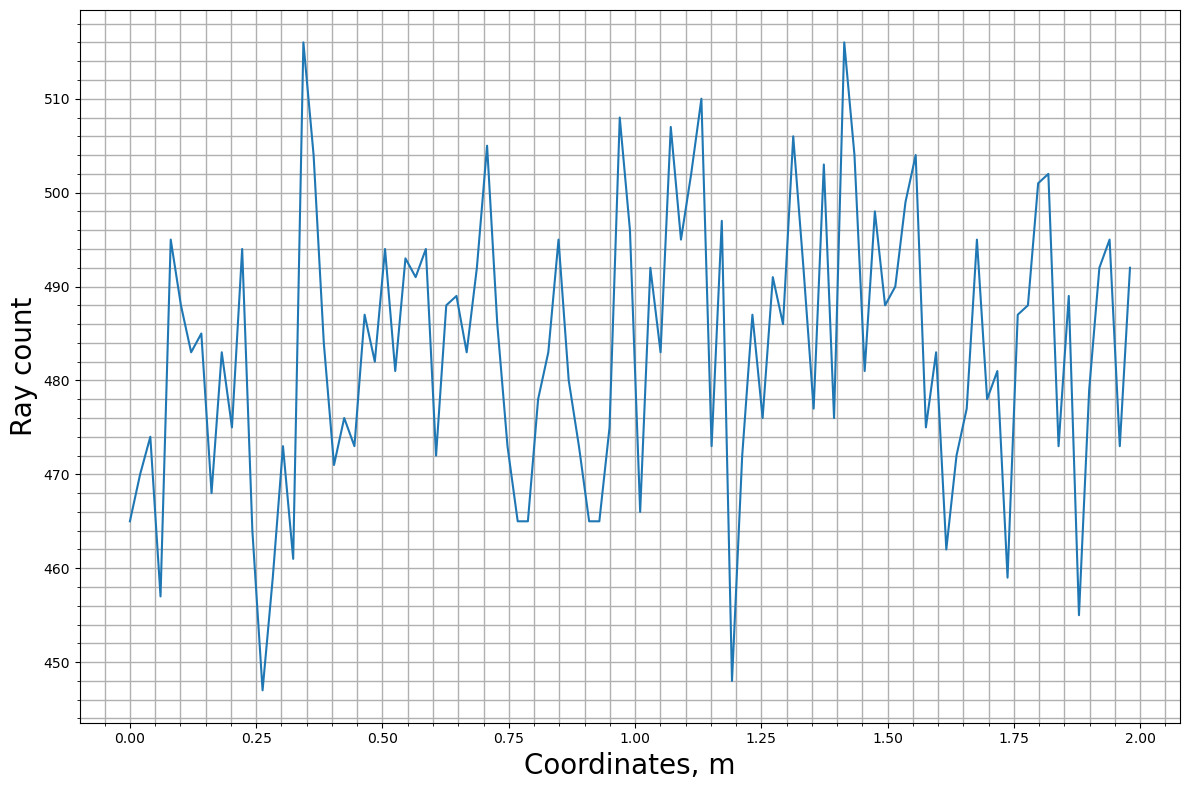

In [10]:
plt.figure(figsize = (12, 8))
plt.plot(x, ray_count_2, label='Rays in 2nd fiber')
plt.xlabel('Coordinates, m', fontsize = 20)
plt.ylabel('Ray count', fontsize = 20)
plt.minorticks_on()
plt.grid(which="both", linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()